
# <font color='white'>**Machine Translation: Italian to English**</font>



# <font color='red'>**Sequence to sequence implementation**</font>

## 1. Simple Encoder and Decoder

1. Implementing a simple Encoder and Decoder architecture  

2. We Use BLEU score as metric to evaluate our model. 

3. We use Tensorboard to plot the Graph, Scores and histograms of gradients. 

**Refer for an intuituve understanding:**

https://medium.com/analytics-vidhya/understand-sequence-to-sequence-models-in-a-more-intuitive-way-1d517d8795bb

https://medium.com/deep-learning-with-keras/lstm-understanding-output-types-e93d2fb57c77

https://towardsdatascience.com/language-translation-with-rnns-d84d43b40571

https://towardsdatascience.com/text-preprocessing-in-natural-language-processing-using-python-6113ff5decd8

https://datascience.stackexchange.com/questions/55112/what-are-ht-1-and-ct-1-for-the-first-lstm-cell

Teacher forcing is a strategy for training recurrent neural networks that uses ground truth as input, instead of model output from a prior time step as an input.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from zipfile import ZipFile
import unicodedata

<font color='blue'>**Load the data**</font>

In [ ]:
!gdown 1hzEJuisyzefygl-A0pn3K6ToVDBSKnGi

Downloading...
From: https://drive.google.com/uc?id=1hzEJuisyzefygl-A0pn3K6ToVDBSKnGi
To: /content/ita-eng.zip
100% 7.78M/7.78M [00:00<00:00, 46.5MB/s]


In [ ]:
filepath = '/content/ita-eng.zip'

contents = ZipFile(filepath).namelist()
print(contents)

['ita.txt', '_about.txt']


In [ ]:
with ZipFile(filepath, 'r') as z: 
    z.extract('ita.txt')

with open('/content/ita.txt', 'r') as data:
    lines = data.readlines()

In [ ]:
print("Total translations:", len(lines))

Total translations: 354238


<font color='blue'>**Preprocess data**</font>

In [ ]:
eng_ita_arr = np.array(list(map(lambda x: x.split('\t')[:-1], lines)))
eng_ita_df = pd.DataFrame({'eng':eng_ita_arr[:,0], 'ita':eng_ita_arr[:,1]})
print(eng_ita_df.shape)
eng_ita_df.head()

(354238, 2)


,eng,ita
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


<font color='blue'>**Preprocess English**</font>

In [ ]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    return phrase

def preprocess_eng(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the special characters: except space ' '
    # remove all text present in brackets  
    text = text.lower()
    text = decontractions(text)
    text = re.sub('-', ' ', text)
    text = re.sub('\(.+\)','', text)
    text = re.sub('[^a-z0-9 ]+', '', text) #A-Z
    text = text.strip()
    text = " ".join(text.split())
    return text

<font color='blue'>**Preprocess Italian**</font>

In [ ]:
#code snippet from - https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string
def remove_accents(phrase): 
    return ''.join(c for c in unicodedata.normalize('NFD', phrase) if unicodedata.category(c) != 'Mn')

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # we have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # you are free to do more proprocessing
    # note that the model will learn better with better preprocessed data 
    
    text = text.lower()
    text = remove_accents(text)
    text = re.sub('-', ' ', text)
    text = re.sub('\(.+\)','', text)
    text = re.sub('[^a-z0-9 ]+', '', text) #A-Z
    text = text.strip()
    text = " ".join(text.split())
    return text

In [ ]:
eng_ita_df['eng'] = eng_ita_df['eng'].apply(preprocess_eng)
eng_ita_df['ita'] = eng_ita_df['ita'].apply(preprocess_ita)
eng_ita_df.head()

,eng,ita
0,hi,ciao
1,hi,ciao
2,run,corri
3,run,corra
4,run,correte


In [ ]:
ita_lengths = eng_ita_df['ita'].str.split().apply(len)
eng_lengths = eng_ita_df['eng'].str.split().apply(len)

<font color='blue'>**Exploring text lengths**</font>

In [ ]:
print('Exploring lengths of italian texts in the next few cells:')
tmp = pd.DataFrame({'percentile':np.arange(0,110,10), 'length':np.percentile(ita_lengths, np.arange(0,110,10))})
tmp

Exploring lengths of italian texts in the next few cells:


,percentile,length
0,0,1.0
1,10,3.0
2,20,4.0
3,30,4.0
4,40,5.0
5,50,5.0
6,60,6.0
7,70,6.0
8,80,7.0
9,90,8.0


In [ ]:
tmp = pd.DataFrame({'percentile':np.arange(90,101,1), 'length':np.percentile(ita_lengths, np.arange(90,101,1))})
tmp

,percentile,length
0,90,8.0
1,91,8.0
2,92,8.0
3,93,9.0
4,94,9.0
5,95,9.0
6,96,9.0
7,97,10.0
8,98,11.0
9,99,12.0


In [ ]:
tmp = pd.DataFrame({'percentile':np.arange(99,100.1,0.1), 'length':np.percentile(ita_lengths, np.arange(99,100.1,0.1))})
tmp

,percentile,length
0,99.0,12.0
1,99.1,12.0
2,99.2,12.0
3,99.3,13.0
4,99.4,13.0
5,99.5,13.0
6,99.6,14.0
7,99.7,15.0
8,99.8,16.0
9,99.9,22.0


In [ ]:
print('Exploring lengths of english texts in the next few cells:')
tmp = pd.DataFrame({'percentile':np.arange(0,110,10), 'length':np.percentile(eng_lengths, np.arange(0,110,10))})
tmp

Exploring lengths of english texts in the next few cells:


,percentile,length
0,0,1.0
1,10,4.0
2,20,4.0
3,30,5.0
4,40,5.0
5,50,6.0
6,60,6.0
7,70,7.0
8,80,7.0
9,90,8.0


In [ ]:
tmp = pd.DataFrame({'percentile':np.arange(90,101,1), 'length':np.percentile(eng_lengths, np.arange(90,101,1))})
tmp

,percentile,length
0,90,8.0
1,91,9.0
2,92,9.0
3,93,9.0
4,94,9.0
5,95,9.0
6,96,10.0
7,97,10.0
8,98,11.0
9,99,12.0


In [ ]:
tmp = pd.DataFrame({'percentile':np.arange(99,100.1,0.1), 'length':np.percentile(eng_lengths, np.arange(99,100.1,0.1))})
tmp

,percentile,length
0,99.0,12.0
1,99.1,12.0
2,99.2,13.0
3,99.3,13.0
4,99.4,13.0
5,99.5,14.0
6,99.6,14.0
7,99.7,15.0
8,99.8,16.0
9,99.9,25.0


In [ ]:
data = eng_ita_df.copy()

In [ ]:
data['ita_len'] = ita_lengths
data['eng_len'] = eng_lengths

In [ ]:
data = data[data['ita_len']<=25]
data = data[data['eng_len']<=25]
data.shape

(353887, 4)

In [ ]:
data['eng_in'] = data['eng'].apply(lambda x: '<start> '+ x)
data['eng_out'] = data['eng'].apply(lambda x:  x +' <end>')
data['eng_tok_in'] = data['eng'].apply(lambda x: '<start> '+ x + ' <end>')
data['ita_in'] = data['ita'].apply(lambda x: '<start> '+ x + ' <end>')

data.drop(columns = ['ita_len', 'eng_len', 'ita', 'eng'], inplace=True)
print(data.shape)
data.head()

(353887, 4)


,eng_in,eng_out,eng_tok_in,ita_in
0,<start> hi,hi <end>,<start> hi <end>,<start> ciao <end>
1,<start> hi,hi <end>,<start> hi <end>,<start> ciao <end>
2,<start> run,run <end>,<start> run <end>,<start> corri <end>
3,<start> run,run <end>,<start> run <end>,<start> corra <end>
4,<start> run,run <end>,<start> run <end>,<start> correte <end>


In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2, random_state=45)

In [ ]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
#tokenize and pad italian texts which will be passed into encoder input
tknizer_ita = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_ita.fit_on_texts(train['ita_in'].values)

#tokenize and pad english texts [note: we fit the tokenizer on eng_texts because it contains both <start> <end> tokens so that we do not have to separately fit on eng_dec_in and eng_dec_out]
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['eng_tok_in'].values)

In [ ]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['ita_in'].values
        self.decoder_inps = data['eng_in'].values
        self.decoder_outs = data['eng_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len
    #refer to understand __getitem__ magic method - https://stackoverflow.com/questions/43627405/understanding-getitem-method
    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len-1, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len-1, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j]) #self.dataset[j]: it fetches padded sequences - self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq and appends to data

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 27)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 27)

train_dataloader = Dataloder(train_dataset, batch_size=1024)
test_dataloader = Dataloder(test_dataset, batch_size=1024)

print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 27) (1024, 26) (1024, 26)


In [ ]:
ita_vocab_size = len(tknizer_ita.word_index)+1 #our word_index doesn't include pad token as it was added later as 0 so (+1) for that
ita_inp_len = 27
print('Italian Vocab Size:', ita_vocab_size) 
print('Italian Sentence Input Length:',ita_inp_len)

Italian Vocab Size: 26409
Italian Sentence Input Length: 27


In [ ]:
eng_vocab_size = len(tknizer_eng.word_index) 
eng_inp_len = 26
print('English Vocab Size:', eng_vocab_size) 
print('English Sentence Input Length:',eng_inp_len)

English Vocab Size: 12936
English Sentence Input Length: 26


## <font color='blue'>**Implement custom encoder decoder**</font>

<font color='blue'>**Encoder**</font>

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Concatenate, Input, TimeDistributed

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super(Encoder,self).__init__()
        self.vocab_size = inp_vocab_size
        self.embedding_dim = embedding_size
        self.input_length = input_length
        self.lstm_size = lstm_size #number of lstm units

        #Initialize Embedding layer
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        
        #Intialize Encoder LSTM layer
        self.lstm = LSTM(units = self.lstm_size, return_sequences=True, return_state=True, name='lstm_encoder')

    def call(self, input_sequence, states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        input_embed = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embed, initial_state = states)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c

    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      
      initial_state_h = tf.zeros(shape = (batch_size, self.lstm_size))
      initial_state_c = tf.zeros(shape = (batch_size, self.lstm_size))
      return  (initial_state_h , initial_state_c)


<font color='blue'>**Decoder**</font>

In [ ]:
class Decoder(tf.keras.Model):
    '''
    Decoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        super(Decoder, self).__init__()
        self.vocab_size = out_vocab_size
        self.embedding_dim = embedding_size
        self.input_length = input_length
        self.lstm_size = lstm_size #number of lstm units

        #Initialize Embedding layer
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_decoder")
        
        #Intialize Decoder LSTM layer
        self.lstm = LSTM(units = self.lstm_size, return_sequences=True, return_state=True, name='lstm_decoder')


    def call(self, input_sequence, initial_states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
        
          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''
        target_embed = self.embedding(input_sequence)
        decoder_out, decoder_state_h, decoder_state_c = self.lstm(target_embed, initial_state = initial_states)
        return decoder_out, decoder_state_h, decoder_state_c

<font color='blue'>**Encoder-Decoder**</font>

In [ ]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self,*params):
        super().__init__()
        self.vocab_size_in = params[0]
        self.vocab_size_out = params[1]
        self.inp_len_enc = params[2]
        self.inp_len_dec = params[3]
        self.embed_size = params[4]
        self.lstm_units = params[5]

        
        #Create encoder object
        self.encoder = Encoder(inp_vocab_size = self.vocab_size_in, embedding_size = self.embed_size ,lstm_size = self.lstm_units, input_length=self.inp_len_enc)
        #Create decoder object
        self.decoder = Decoder(out_vocab_size = self.vocab_size_out, embedding_size = self.embed_size ,lstm_size = self.lstm_units, input_length=self.inp_len_dec)
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        self.dense = Dense(self.vocab_size_out, activation='softmax') 
    
    
    def call(self, input):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''
        input_sequence, target_sequence = input
       
        init_state = self.encoder.initialize_states(1024) #batch_size=1024 (self.batch_size)
       
        encoder_out, encoder_state_h, encoder_state_c = self.encoder(input_sequence, states = init_state)
       
        decoder_out, decoder_state_h, decoder_state_c = self.decoder(target_sequence, initial_states = (encoder_state_h, encoder_state_c))
  
        dense_out = self.dense(decoder_out)
        
        return dense_out

<font color='blue'>**Model Training and Evaluation**</font>

In [ ]:
import os 
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping

In [ ]:
%load_ext tensorboard

In [ ]:
#callbacks 
tensorboard_cb_dict = {}
for i in range(1,5):
    log_dir = os.path.join(f'logs_model_{i}','fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_cb_dict[i] = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

reducelr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=0, mode='min', min_delta=0.0001, min_lr=0.0001)

earlystop_cb = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, verbose=1, mode='min', restore_best_weights=True)

callbacks_1 = [tensorboard_cb_dict[1], reducelr_cb, earlystop_cb]

In [ ]:
#model build
tf.keras.utils.set_random_seed(0)
tf.keras.backend.clear_session()

inp_vocab_size = ita_vocab_size
out_vocab_size = eng_vocab_size
encoder_input_length  = ita_inp_len
decoder_input_length = eng_inp_len
embedding_size = 20
lstm_units = 256

# Create an object of encoder_decoder Model class 
model = Encoder_decoder(inp_vocab_size, out_vocab_size, encoder_input_length, decoder_input_length, embedding_size, lstm_units)

In [ ]:
#steps 
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024

train_steps, valid_steps

(276, 69)

In [ ]:
# Compile the model and fit the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy')
history = model.fit(x = train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=test_dataloader, validation_steps=valid_steps, verbose=2, callbacks=callbacks_1)

Epoch 1/20
276/276 - 84s - loss: 1.3146 - val_loss: 1.1410 - lr: 0.0100 - 84s/epoch - 303ms/step
Epoch 2/20
276/276 - 75s - loss: 0.9164 - val_loss: 0.6538 - lr: 0.0100 - 75s/epoch - 273ms/step
Epoch 3/20
276/276 - 75s - loss: 0.4893 - val_loss: 0.3847 - lr: 0.0100 - 75s/epoch - 272ms/step
Epoch 4/20
276/276 - 76s - loss: 0.3032 - val_loss: 0.2846 - lr: 0.0100 - 76s/epoch - 274ms/step
Epoch 5/20
276/276 - 75s - loss: 0.2176 - val_loss: 0.2388 - lr: 0.0100 - 75s/epoch - 273ms/step
Epoch 6/20
276/276 - 75s - loss: 0.1711 - val_loss: 0.2151 - lr: 0.0100 - 75s/epoch - 272ms/step
Epoch 7/20
276/276 - 75s - loss: 0.1426 - val_loss: 0.2005 - lr: 0.0100 - 75s/epoch - 273ms/step
Epoch 8/20
276/276 - 75s - loss: 0.1229 - val_loss: 0.1925 - lr: 0.0100 - 75s/epoch - 272ms/step
Epoch 9/20
276/276 - 75s - loss: 0.1092 - val_loss: 0.1875 - lr: 0.0100 - 75s/epoch - 272ms/step
Epoch 10/20
276/276 - 75s - loss: 0.0983 - val_loss: 0.1852 - lr: 0.0100 - 75s/epoch - 272ms/step
Epoch 11/20
276/276 - 75s - l

- Blue represents Validation
- Orange represents Train

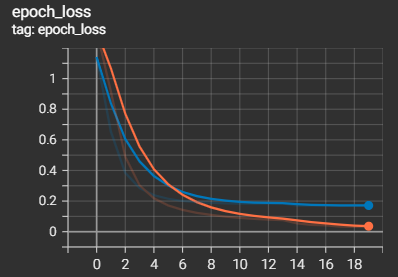

In [ ]:
def predict(input_sentence): #inference code

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predicted_out,state_h,state_c=model.layers[1](dec_input,states)
         pass the predicted_out to the dense layer
         update the states=[state_h,state_c]
         And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
         Update the input_to_decoder with current predictions
  F. Return the predicted sentence
  '''
  MAX_LEN = 27

  input_ita = [input_sentence]
  encoder_seq = tknizer_ita.texts_to_sequences(input_ita)
  encoder_seq = pad_sequences(encoder_seq, maxlen= MAX_LEN, dtype='int32', padding='post')
  
  enc_initial_state = model.layers[0].initialize_states(len(encoder_seq)) #number of encoder sequences = 1 (our function predits one at a time)
  enc_out, enc_state_h, enc_state_c = model.layers[0](encoder_seq, states = enc_initial_state) 
  states_values = [enc_state_h, enc_state_c] #encoder final states

  pred = []
  cur_vec = np.ones((1, 1)) #initialize index of <start> token from word_index (i.e. 1)

  for i in range(MAX_LEN):
    cur_emb = model.layers[1].embedding(cur_vec) #pass the current word token through embedding layer

    infe_output, state_h, state_c = model.layers[1].lstm(cur_emb, initial_state=states_values) #pass the embedded word vector through lstm cell

    infe_output = model.layers[2](infe_output) #pass the output of lstm cell through softmax layer of size eng_vocab s.t. each value denotes probability of the word in vocab as output  

    states_values = [state_h, state_c] 
    cur_vec = np.reshape(np.argmax(infe_output), (1, 1)) #get the word with highest probability using argmax
    pred.append(cur_vec) 
    
    #break the loop once <end> token is returned i.e. index=2  
    if cur_vec[0,0] == 2:
      break
  
  pred_seq = np.stack(pred, 2)[0]
  pred_text = tknizer_eng.sequences_to_texts(pred_seq)[0] #convert the sequence to text 
  
  return pred_text

In [ ]:
import nltk.translate.bleu_score as bleu
from nltk.translate.bleu_score import SmoothingFunction

def calculate_bleu(inputs):
  
  input, translation = inputs[0], inputs[1]
  references = validation[validation['ita_in']==input]['eng_out'].tolist()
  references = list(map(lambda x: x.split()[0:-1],references))
  
  translation = translation.split()[:-1]

  chencherry = SmoothingFunction()
  score = bleu.sentence_bleu(references, translation, smoothing_function = chencherry.method1)

  return score

In [ ]:
#testing predict and calculate_bleu function
print('Input:', validation['ita_in'][296585])
print('Translation:',predict(validation['ita_in'][296585]))
print('BLEU Score:',calculate_bleu((validation['ita_in'][296585], predict(validation['ita_in'][296585]))))

Input: <start> non voglio essere suo amico <end>
Translation: i do not want to be friends with you <end>
BLEU Score: 1.0


In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html
import random 

rand_sentences = random.sample(validation['ita_in'].tolist(), 1000)
translated_senetences = list(map(lambda x: predict(x), rand_sentences))
bleu_inputs = list(zip(rand_sentences, translated_senetences))
bleu_scores = list(map(lambda x: calculate_bleu(x), bleu_inputs))
average_bleu_score = np.mean(bleu_scores)

print("Average Bleu Scores:", average_bleu_score)

Average Bleu Scores: 0.6723495468212515


## 2. Including Attention mechanisum

1. Using the preprocessed data from Part-1

2. We implement an Encoder and Decoder architecture with  
attention.

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * Attention Layer
3. In Global attention, we have 3 types of scoring functions
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 you need to implemnt "dot" score function
    * In model 2 you need to implemnt "general" score function
    * In model 3 you need to implemnt "concat" score function.<br>
    
4. We train the model with simple model.fit() only.

5. Using attention weights, we create the attention plots
6. The attention layer is subclassed from tf.keras.layers to have custom functionality

7. Class OneStepDecoder is subclassed from tf.keras.Model fro custom functionality.

9. Using BLEU score as metric to evaluate models. 
10. Using Tensorboard to plot the Graph, Scores and histograms of gradients. 

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_dim,enc_units,input_length):

        #Initialize Embedding layer
        super(Encoder,self).__init__()
        self.vocab_size = inp_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.lstm_size = enc_units #number of lstm units

        #Initialize Embedding layer
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        
        #Intialize Encoder LSTM layer
        self.lstm = LSTM(units = self.lstm_size, return_sequences=True, return_state=True, name='lstm_encoder')

    def call(self,input_sequence,states):
      '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
      '''
      input_embed = self.embedding(input_sequence)
      self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embed, initial_state = states)
      return self.lstm_output, self.lstm_state_h,self.lstm_state_c

    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      initial_state_h = tf.zeros(shape = (batch_size, self.lstm_size))
      initial_state_c = tf.zeros(shape = (batch_size, self.lstm_size))
      return  (initial_state_h , initial_state_c)

<font color='blue'>**Attention**</font>

at every timestep of decoder lstm, we have hidden state vector hd of shape (1,256) we take similarity of hd with he all states 

In [ ]:
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):
        super().__init__()
        
        self.score_fun = scoring_function

        if self.score_fun == 'general':
            #W
            #note: we assuming that decoder units and encoder units are equal dec_units = enc_units = att_units  
            self.W = tf.random.uniform(shape=[att_units,att_units]) 

        elif self.score_fun == 'concat':
            #W1
            self.W1 = tf.random.uniform(shape=[att_units,att_units])
            #W2
            self.W2 = tf.random.uniform(shape=[att_units,att_units])
            #v 
            self.V1 = tf.random.uniform(shape=[att_units,1])
  
  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    
    if self.score_fun == 'dot':
        # Implement Dot score function here

        decoder_hidden_state=tf.expand_dims(decoder_hidden_state,2)
        attention_weights=tf.matmul(encoder_output,decoder_hidden_state)
        attention_weights=tf.nn.softmax(attention_weights,axis=1)
        context_vector = attention_weights*encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)

        
    elif self.score_fun == 'general':
        decoder_hidden_state=tf.matmul(decoder_hidden_state,self.W)
        decoder_hidden_state=tf.expand_dims(decoder_hidden_state,2)
        attention_weights=tf.matmul(encoder_output,decoder_hidden_state)
        attention_weights=tf.nn.softmax(attention_weights,axis=1)
        context_vector=attention_weights*encoder_output
        context_vector=tf.reduce_sum(context_vector,axis=1)

        
    elif self.score_fun == 'concat':
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state,1)
        attention_weights = tf.matmul(tf.nn.tanh(tf.matmul(decoder_hidden_state,self.W1) + tf.matmul(encoder_output,self.W2)),self.V1)
        attention_weights=tf.nn.softmax(attention_weights,axis=1)
        context_vector = attention_weights*encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)

        
    return context_vector,attention_weights

<font color='blue'>**OneStepDecoder**</font>

In [ ]:
class OneStepDecoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):

      # Initialize decoder embedding layer, LSTM and any other objects needed
        super(OneStepDecoder, self).__init__()
        self.vocab_size = tar_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.lstm_size = dec_units #number of lstm units
        self.att_units = att_units
        self.score_func = score_fun

        #Initialize necessary layers
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_onestepdecoder")
        
        self.attention = Attention(self.score_func, self.att_units )
        
        self.concat = Concatenate(name='concat_onestepdecoder')

        self.lstm = LSTM(units = self.lstm_size, return_sequences=True, return_state=True, name='lstm_onestepdecoder')

        self.dense = Dense(units = self.vocab_size, activation='softmax')


  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''
    #for each input word get the context vector using attention mechanism and cocat them together before inputting to lstm cell
    input_word_embed = self.embedding(input_to_decoder)

    context_vector, attention_weights = self.attention(state_h, encoder_output) 
    context_vector_reshaped = tf.expand_dims(context_vector, 1)

    decoder_input = self.concat([context_vector_reshaped, input_word_embed])

    dec_output, dec_state_h, dec_state_c = self.lstm(decoder_input, initial_state = [state_h, state_c])

    dec_output = tf.reshape(dec_output, (dec_output.shape[0],dec_output.shape[2]))

    #get the output vector at timestep t which represents the probability of each word in vocab
    #the word with highest probability is the predicted word which is fed as input at timestep t+1 
    output = self.dense(dec_output)
    
    return output, dec_state_h, dec_state_c, attention_weights, context_vector

<font color='blue'>**Decoder**</font>

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        #Intialize necessary variables and create an object from the class onestepdecoder
        super(Decoder, self).__init__()
        self.vocab_size = out_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.lstm_size = dec_units #number of lstm units in decoder lstm layer
        self.att_units = att_units #number of units in attention layer
        self.score_fun = score_fun 


        self.one_step_decoder = OneStepDecoder(tar_vocab_size = self.vocab_size, embedding_dim = self.embedding_dim, input_length = self.input_length, 
                                              dec_units = self.lstm_size ,score_fun = self.score_fun, att_units = self.att_units)


    @tf.function
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        #It supports gradient back-propagation via special "flow" control flow dependencies.
        all_outputs = tf.TensorArray(tf.float32, size = self.input_length, name='output_arrays') #this stores arrays of length vocab_size corr. to each word in the sequence 
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        for timestep in range(self.input_length): 
            output, decoder_hidden_state, decoder_cell_state, attention_weights, context_vector = self.one_step_decoder(input_to_decoder[:, timestep:timestep+1], encoder_output,  
                                                                                                                        decoder_hidden_state, decoder_cell_state)
            all_outputs = all_outputs.write(timestep, output)
        

        #in case of 3 dims we need to specify which dimensions neeed to be transposed so the natural form is [0,1,2] -> interchanged  [1,0,2]
        all_outputs = tf.transpose(all_outputs.stack(),[1,0,2]) 
        return all_outputs

<font color='blue'>**Encoder Decoder model**</font>

In [ ]:
class encoder_decoder(tf.keras.Model):
    def __init__(self,*params):
        #Initialize objects from encoder decoder
        super().__init__()
        self.vocab_size_in = params[0]
        self.vocab_size_out = params[1]
        self.inp_len_enc = params[2]
        self.inp_len_dec = params[3]
        self.embed_size = params[4]
        self.lstm_units = params[5]
        self.score_fun= params[6]
        self.att_units = params[7]
        
        #Create encoder object
        self.encoder = Encoder(inp_vocab_size = self.vocab_size_in, embedding_dim = self.embed_size ,enc_units = self.lstm_units, input_length=self.inp_len_enc)
        
        #Create decoder object
        self.decoder = Decoder(out_vocab_size = self.vocab_size_out, embedding_dim = self.embed_size ,dec_units = self.lstm_units, input_length=self.inp_len_dec, 
                               score_fun = self.score_fun, att_units = self.att_units)
  
    def call(self,data):
        
        # Decoder initial states are encoder final states, Initialize it accordingly
        # Pass the decoder sequence,encoder_output,decoder states to Decoder
        # return the decoder output
        
        input_sequence, target_sequence = data

        init_state = self.encoder.initialize_states(1024) #Intialize encoder states, Pass the encoder_sequence to the embedding layer batch_size=1024

        encoder_out, encoder_state_h, encoder_state_c = self.encoder(input_sequence, states = init_state)

        outputs = self.decoder(target_sequence, encoder_out, encoder_state_h, encoder_state_c)
        
        return outputs

<font color='blue'>**Custom loss function**</font>

In [ ]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model

"""The from_logits=True attribute inform the loss function that the output values generated by the model are not normalized, a.k.a. logits. 
In other words, the softmax function has not been applied on them to produce a probability distribution. 
Therefore, the output layer in this case does not have a softmax activation function:
out = tf.keras.layers.Dense(n_units)  # <-- linear activation function
The softmax function would be automatically applied on the output values by the loss function. 
Therefore, this does not make a difference with the scenario when you use from_logits=False (default) and a softmax activation function on last layer; """

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction='none') #one step decoder has last layer as softmax so we keep from_logits=False



def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.

    """
    
    # tf.math.equal(real, 0) ->  Returns the truth value of (x == y) element-wise. 
    # tf.math.logical_not(x) -> Returns the truth value of NOT x element-wise.
    # e.g. real = [23,4,65,32,0,0,0] -> not(False),not(False),not(False),not(False), not(True), not(True), not(True) -> True,True,True,True,False,False,False 
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype) #casted to 1s and 0s 
    loss_ *= mask #loss value is only valid at non padded positions (i.e. 1s)

    return tf.reduce_mean(loss_)

<font color='blue' size=5>**Dot Scoring Function**</font>

<font color='blue'>**Training**</font>


In [ ]:
# model build
inp_vocab_size = ita_vocab_size
out_vocab_size = eng_vocab_size
encoder_input_length  = ita_inp_len
decoder_input_length = eng_inp_len
embedding_size = 20
lstm_units = 256
scoring = 'dot'
att_units = 256 

tf.keras.utils.set_random_seed(0)
tf.keras.backend.clear_session()

# Create an object of encoder_decoder Model class 
model_2 = encoder_decoder(inp_vocab_size, out_vocab_size, encoder_input_length, decoder_input_length, embedding_size, lstm_units, scoring, att_units)

In [ ]:
#callbacks and steps
callbacks_2 = [tensorboard_cb_dict[2], reducelr_cb, earlystop_cb]

train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024

train_steps, valid_steps

(276, 69)

In [ ]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=loss_function)
history_2 = model_2.fit(x = train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=test_dataloader, 
                        validation_steps=valid_steps, verbose=2, callbacks=callbacks_2)

Epoch 1/20
276/276 - 250s - loss: 1.3148 - val_loss: 1.1394 - lr: 0.0100 - 250s/epoch - 905ms/step
Epoch 2/20
276/276 - 189s - loss: 0.9992 - val_loss: 0.8354 - lr: 0.0100 - 189s/epoch - 686ms/step
Epoch 3/20
276/276 - 190s - loss: 0.5556 - val_loss: 0.4004 - lr: 0.0100 - 190s/epoch - 687ms/step
Epoch 4/20
276/276 - 190s - loss: 0.3100 - val_loss: 0.2888 - lr: 0.0100 - 190s/epoch - 688ms/step
Epoch 5/20
276/276 - 190s - loss: 0.2192 - val_loss: 0.2412 - lr: 0.0100 - 190s/epoch - 689ms/step
Epoch 6/20
276/276 - 189s - loss: 0.1728 - val_loss: 0.2164 - lr: 0.0100 - 189s/epoch - 686ms/step
Epoch 7/20
276/276 - 190s - loss: 0.1446 - val_loss: 0.2025 - lr: 0.0100 - 190s/epoch - 688ms/step
Epoch 8/20
276/276 - 190s - loss: 0.1254 - val_loss: 0.1937 - lr: 0.0100 - 190s/epoch - 687ms/step
Epoch 9/20
276/276 - 190s - loss: 0.1117 - val_loss: 0.1886 - lr: 0.0100 - 190s/epoch - 687ms/step
Epoch 10/20
276/276 - 190s - loss: 0.1011 - val_loss: 0.1841 - lr: 0.0100 - 190s/epoch - 688ms/step
Epoch 11/

- Blue represents Validation
- Orange represents Train

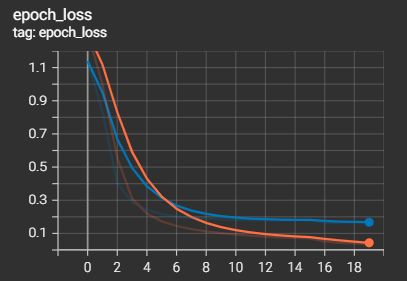

## <font color='blue'>**Inference**</font>

<font color='blue'>**Plot attention weights**</font>

In [ ]:
def plot_attention(sentence, predicted_sentence, attention_matrix):
    #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate
    plt.figure(figsize=(15,10))
    ax = sns.heatmap(attention_matrix, cmap='BuPu', annot=True, fmt='.2g')
    fontdict = {'fontsize': 15}
    ax.set_xticklabels(sentence.split(), fontdict=fontdict, rotation=90)
    ax.set_yticklabels(predicted_sentence.split(), fontdict=fontdict)
    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')
    plt.suptitle('Attention weights')
    return plt.show()

<font color='blue'>**Predict the sentence translation**</font>

In [ ]:
def predict_w_att(input_sentence, model):
    """ A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
    D. till we reach max_length of decoder or till the model predicted word <end>
         predicted_out,state_h,state_c=model.layers[1](dec_input,states)
         pass the predicted_out to the dense layer
         update the states=[state_h,state_c]
         And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
         Update the input_to_decoder with current predictions
    F. Return the predicted sentence """
    
    MAX_LEN = 27
    input_ita = [input_sentence] 
    encoder_seq = tknizer_ita.texts_to_sequences(input_ita) 
    encoder_seq = pad_sequences(encoder_seq, maxlen= MAX_LEN, dtype='int32', padding='post') 

    enc_initial_state = model.layers[0].initialize_states(len(encoder_seq)) 
    enc_out, enc_state_h, enc_state_c = model.layers[0](encoder_seq, states = enc_initial_state)
    states_values = [enc_state_h, enc_state_c] 

    pred = []
    cur_vec = np.ones((1, 1)) #[[1]] -> 1 : <start> for first input to decoder #np.ones instead of np.zeros 
    att_per_token = []

    for i in range(MAX_LEN):
 
        infe_output, state_h, state_c, attention_weights, context_vector = model.layers[1].one_step_decoder(cur_vec, enc_out, states_values[0], states_values[1]) 
        
        states_values = [state_h, state_c]
        cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
        
        pred.append(cur_vec)
        att_per_token.append(attention_weights)

        #break the loop once <end> token is returned
        if (cur_vec[0,0] == 2):
            break
        

    pred_seq = np.stack(pred, 2)[0]
    pred_text = tknizer_eng.sequences_to_texts(pred_seq)[0]

    att_matrix = np.stack(att_per_token, 0)
    att_matrix = att_matrix.reshape(-1,27)
    original_len = len(input_sentence.split())

    return pred_text, att_matrix[:, :original_len]

**Testing predict_w_att and plot_attention functions on a random record from validation set**

Input: <start> chi ha difeso tom <end>
Translation: who has tom ever reply <end>


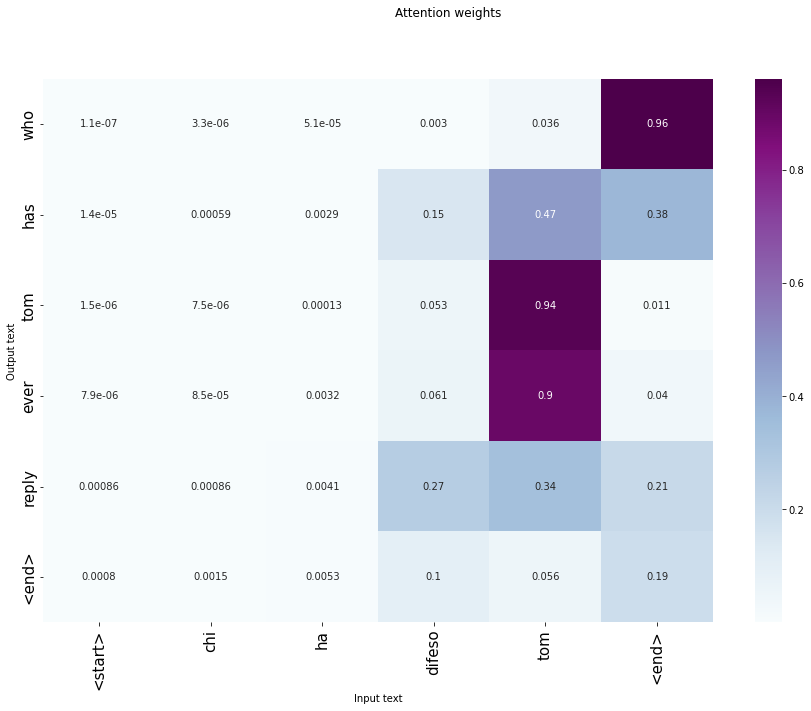

In [ ]:

print('Input:', validation['ita_in'][43817])
print('Translation:', predict_w_att(validation['ita_in'][43817], model_2)[0])
plot_attention(validation['ita_in'][43817], predict_w_att(validation['ita_in'][43817], model_2)[0], predict_w_att(validation['ita_in'][43817], model_2)[1])

<font color='blue'>**Calculate BLEU score**</font>

In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
import random
rand_sentences = random.sample(validation['ita_in'].tolist(), 1000)
translated_senetences = list(map(lambda x: predict_w_att(x, model_2)[0], rand_sentences))
bleu_inputs = list(zip(rand_sentences, translated_senetences))
bleu_scores = list(map(lambda x: calculate_bleu(x), bleu_inputs))
average_bleu_score = np.mean(bleu_scores)

print("Average Bleu Scores:", average_bleu_score)

Average Bleu Scores: 0.6969677711045861


**Plotting attention matrix for a couple of random records**

Input: <start> io penso che tom stia solo fingendo di dormire <end>
Translation: i think tom is only pretending to be asleep <end>


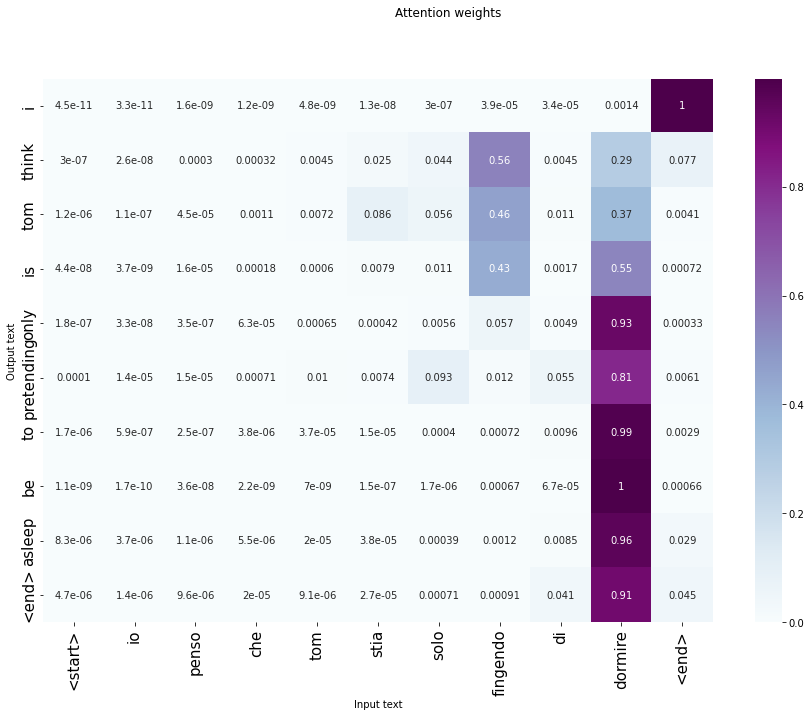

In [ ]:
print('Input:',rand_sentences[6])
print('Translation:',predict_w_att(rand_sentences[6], model_2)[0])
plot_attention(rand_sentences[6], predict_w_att(rand_sentences[6], model_2)[0], predict_w_att(rand_sentences[6], model_2)[1])

Input: <start> lasciatemi spiegare <end>
Translation: let me explain <end>


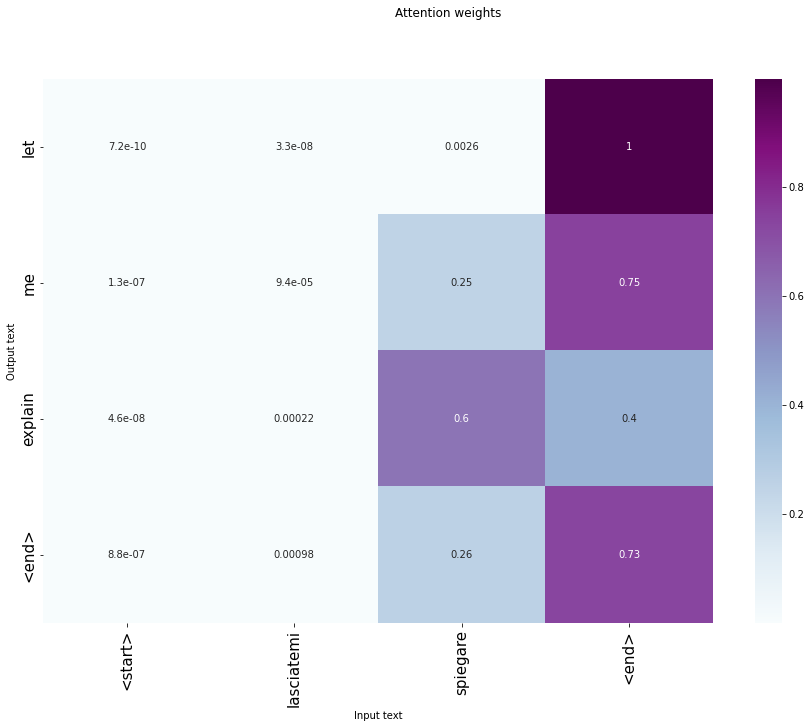

In [ ]:
print('Input:',rand_sentences[512])
print('Translation:',predict_w_att(rand_sentences[512], model_2)[0])
plot_attention(rand_sentences[512], predict_w_att(rand_sentences[512], model_2)[0], predict_w_att(rand_sentences[512], model_2)[1])

<font color='blue' size=5>**General scoring function**</font>

In [ ]:
# model build
inp_vocab_size = ita_vocab_size
out_vocab_size = eng_vocab_size
encoder_input_length  = ita_inp_len
decoder_input_length = eng_inp_len
embedding_size = 20
lstm_units = 256
scoring = 'general'
att_units = 256

tf.keras.utils.set_random_seed(0)
tf.keras.backend.clear_session()

# Create an object of encoder_decoder Model class 
model_3 = encoder_decoder(inp_vocab_size, out_vocab_size, encoder_input_length, decoder_input_length, embedding_size, lstm_units, scoring, att_units)

In [ ]:
#callbacks and steps
callbacks_3 = [tensorboard_cb_dict[3], reducelr_cb, earlystop_cb]

train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024

train_steps, valid_steps

(276, 69)

In [ ]:
#compile and train
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=loss_function)
history_3 = model_3.fit(x = train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=test_dataloader, 
                        validation_steps=valid_steps, verbose=2, callbacks=callbacks_3)

Epoch 1/20
276/276 - 254s - loss: 1.3025 - val_loss: 1.1194 - lr: 0.0100 - 254s/epoch - 920ms/step
Epoch 2/20
276/276 - 193s - loss: 0.8340 - val_loss: 0.5449 - lr: 0.0100 - 193s/epoch - 699ms/step
Epoch 3/20
276/276 - 193s - loss: 0.4057 - val_loss: 0.3307 - lr: 0.0100 - 193s/epoch - 699ms/step
Epoch 4/20
276/276 - 193s - loss: 0.2553 - val_loss: 0.2576 - lr: 0.0100 - 193s/epoch - 701ms/step
Epoch 5/20
276/276 - 193s - loss: 0.1895 - val_loss: 0.2233 - lr: 0.0100 - 193s/epoch - 700ms/step
Epoch 6/20
276/276 - 193s - loss: 0.1529 - val_loss: 0.2057 - lr: 0.0100 - 193s/epoch - 699ms/step
Epoch 7/20
276/276 - 193s - loss: 0.1300 - val_loss: 0.1951 - lr: 0.0100 - 193s/epoch - 700ms/step
Epoch 8/20
276/276 - 193s - loss: 0.1139 - val_loss: 0.1881 - lr: 0.0100 - 193s/epoch - 700ms/step
Epoch 9/20
276/276 - 193s - loss: 0.1027 - val_loss: 0.1835 - lr: 0.0100 - 193s/epoch - 699ms/step
Epoch 10/20
276/276 - 196s - loss: 0.0945 - val_loss: 0.1817 - lr: 0.0100 - 196s/epoch - 709ms/step
Epoch 11/

- Blue represents Validation
- Orange represents Train

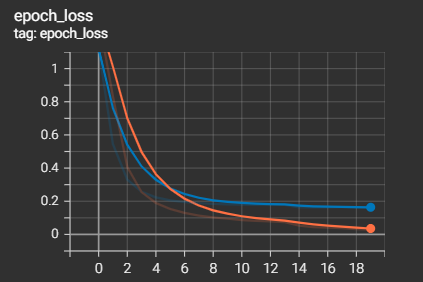

In [ ]:
import random
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
rand_sentences = random.sample(validation['ita_in'].tolist(), 1000)
translated_senetences = list(map(lambda x: predict_w_att(x, model_3)[0], rand_sentences))
bleu_inputs = list(zip(rand_sentences, translated_senetences))
bleu_scores = list(map(lambda x: calculate_bleu(x), bleu_inputs))
average_bleu_score = np.mean(bleu_scores)

print("Average Bleu Scores:", average_bleu_score)

Average Bleu Scores: 0.6894557010429335


**Plotting attention matrix for a couple of random records**


Input: <start> io penso che tom stia solo fingendo di dormire <end>
Translation: i think tom is only pretending to be asleep <end>


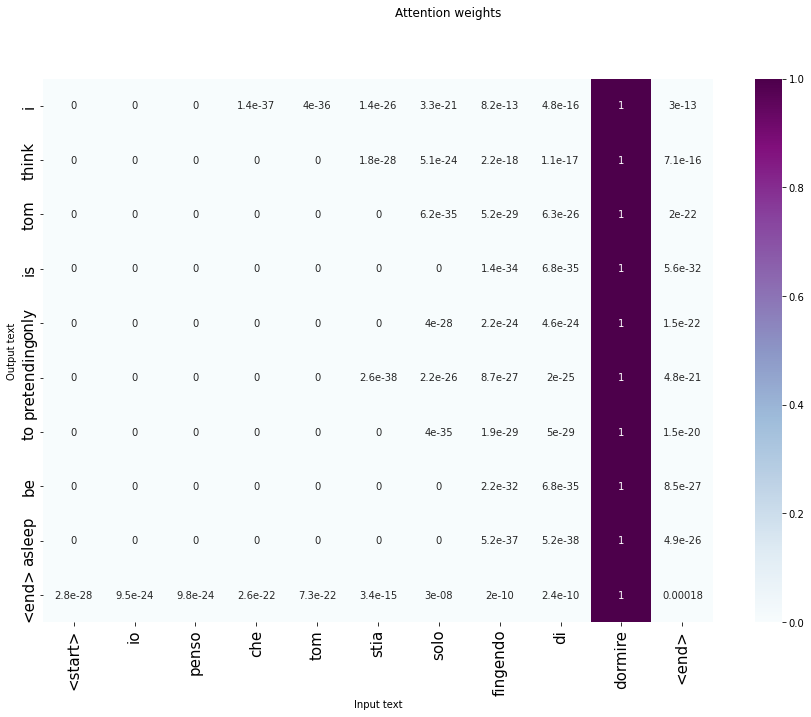

In [ ]:
print('Input:',rand_sentences[6])
print('Translation:',predict_w_att(rand_sentences[6], model_3)[0])
plot_attention(rand_sentences[6], predict_w_att(rand_sentences[6], model_3)[0], predict_w_att(rand_sentences[6], model_3)[1])

Input: <start> lasciatemi spiegare <end>
Translation: let me explain <end>


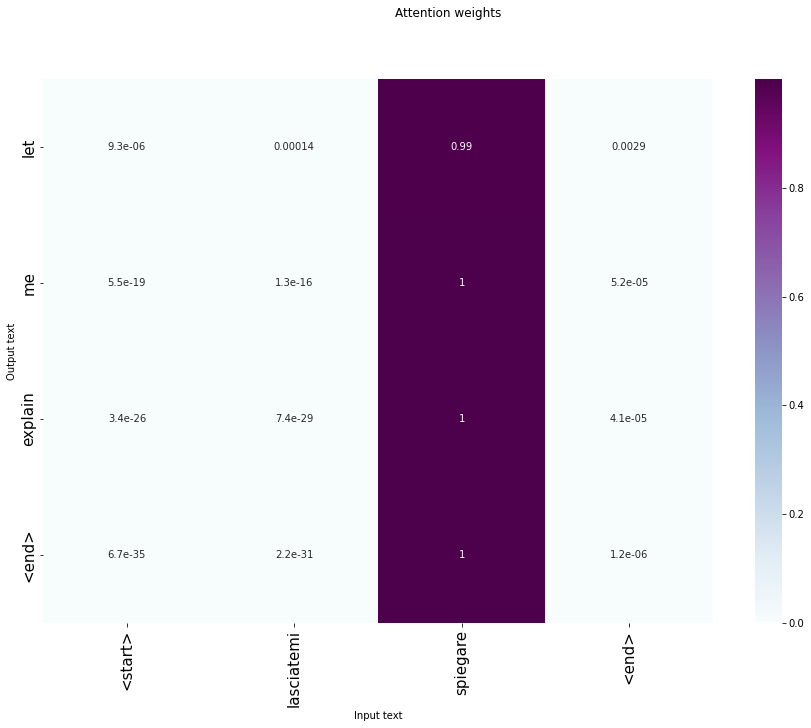

In [ ]:
print('Input:',rand_sentences[512])
print('Translation:',predict_w_att(rand_sentences[512], model_3)[0])
plot_attention(rand_sentences[512], predict_w_att(rand_sentences[512], model_3)[0], predict_w_att(rand_sentences[512], model_3)[1])

<font color='blue' size=5>**Concat scoring function**</font>

In [ ]:
# model build
inp_vocab_size = ita_vocab_size
out_vocab_size = eng_vocab_size
encoder_input_length  = ita_inp_len
decoder_input_length = eng_inp_len
embedding_size = 20
lstm_units = 256
scoring = 'concat'
att_units = 256

tf.keras.utils.set_random_seed(0)
tf.keras.backend.clear_session()

# Create an object of encoder_decoder Model class 
model_4 = encoder_decoder(inp_vocab_size, out_vocab_size, encoder_input_length, decoder_input_length, embedding_size, lstm_units, scoring, att_units)

In [ ]:
#callbacks and steps
callbacks_4 = [tensorboard_cb_dict[4], reducelr_cb, earlystop_cb]

train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024

train_steps, valid_steps

(276, 69)

In [ ]:
#compile and train
model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=loss_function)
history_4 = model_4.fit(x = train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=test_dataloader, 
                        validation_steps=valid_steps, verbose=2, callbacks=callbacks_4)

Epoch 1/20
276/276 - 280s - loss: 1.2557 - val_loss: 1.0011 - lr: 0.0100 - 280s/epoch - 1s/step
Epoch 2/20
276/276 - 217s - loss: 0.7787 - val_loss: 0.5502 - lr: 0.0100 - 217s/epoch - 786ms/step
Epoch 3/20
276/276 - 217s - loss: 0.4221 - val_loss: 0.3479 - lr: 0.0100 - 217s/epoch - 787ms/step
Epoch 4/20
276/276 - 217s - loss: 0.2728 - val_loss: 0.2711 - lr: 0.0100 - 217s/epoch - 786ms/step
Epoch 5/20
276/276 - 217s - loss: 0.2043 - val_loss: 0.2351 - lr: 0.0100 - 217s/epoch - 785ms/step
Epoch 6/20
276/276 - 217s - loss: 0.1656 - val_loss: 0.2149 - lr: 0.0100 - 217s/epoch - 786ms/step
Epoch 7/20
276/276 - 217s - loss: 0.1407 - val_loss: 0.2028 - lr: 0.0100 - 217s/epoch - 785ms/step
Epoch 8/20
276/276 - 217s - loss: 0.1230 - val_loss: 0.1956 - lr: 0.0100 - 217s/epoch - 785ms/step
Epoch 9/20
276/276 - 216s - loss: 0.1106 - val_loss: 0.1895 - lr: 0.0100 - 216s/epoch - 784ms/step
Epoch 10/20
276/276 - 216s - loss: 0.1007 - val_loss: 0.1869 - lr: 0.0100 - 216s/epoch - 783ms/step
Epoch 11/20


- Blue represents Validation
- Orange represents Train

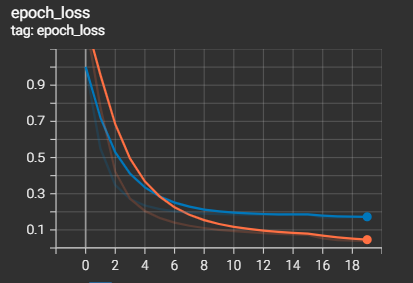

In [ ]:
import random
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
rand_sentences = random.sample(validation['ita_in'].tolist(), 1000)
translated_senetences = list(map(lambda x: predict_w_att(x, model_4)[0], rand_sentences))
bleu_inputs = list(zip(rand_sentences, translated_senetences))
bleu_scores = list(map(lambda x: calculate_bleu(x), bleu_inputs))
average_bleu_score = np.mean(bleu_scores)

print("Average Bleu Scores:", average_bleu_score)

Average Bleu Scores: 0.6724567252770882


**Plotting attention matrix for a couple of random records**

Input: <start> casa mia e su una collina <end>
Translation: my house is on a hill <end>


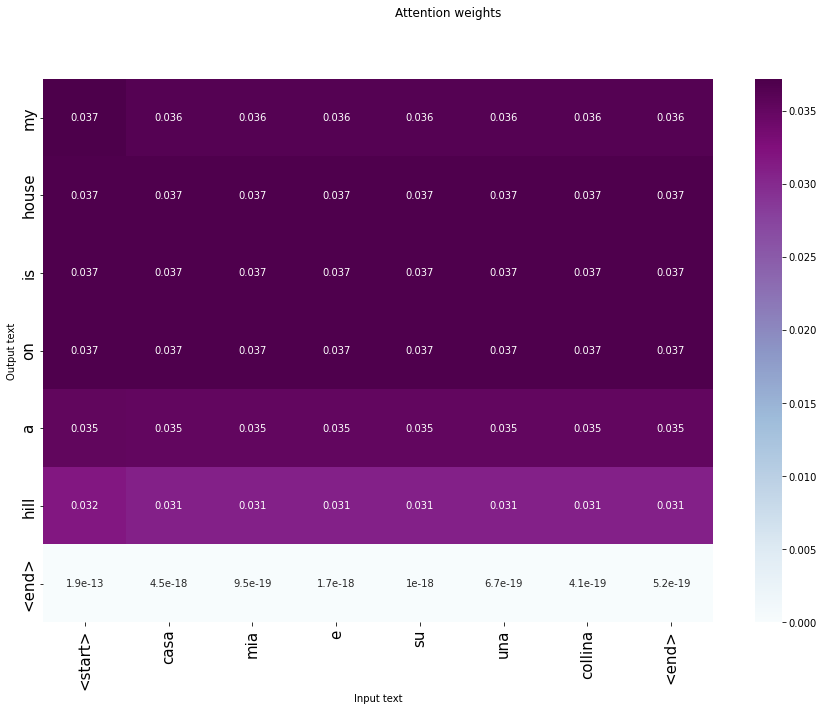

In [ ]:
print('Input:',rand_sentences[26])
print('Translation:',predict_w_att(rand_sentences[26], model_4)[0])
plot_attention(rand_sentences[26], predict_w_att(rand_sentences[26], model_4)[0], predict_w_att(rand_sentences[26], model_4)[1])

Input: <start> non sa leggere <end>
Translation: she can not read <end>


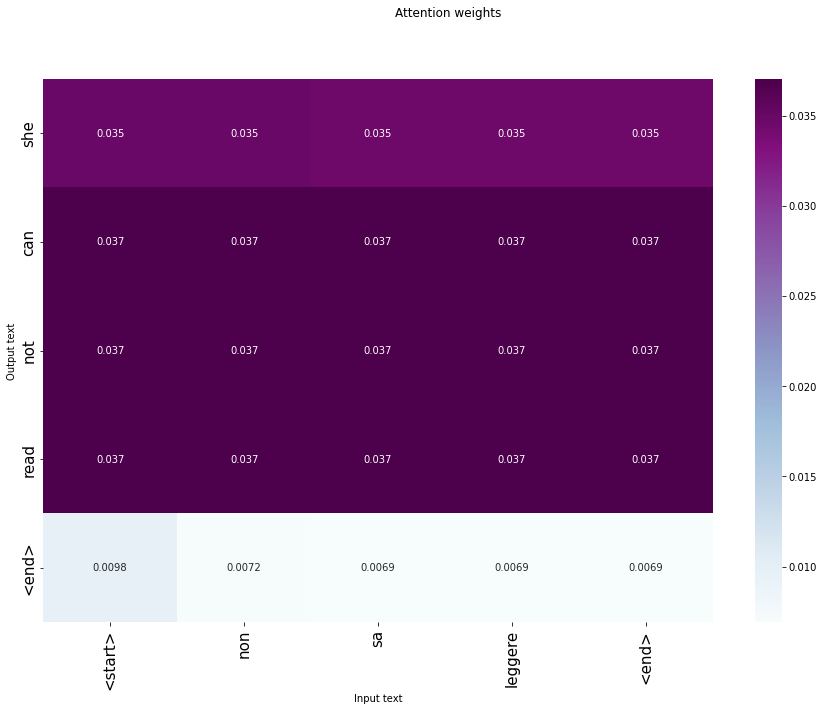

In [ ]:
print('Input:',rand_sentences[256])
print('Translation:',predict_w_att(rand_sentences[256], model_4)[0])
plot_attention(rand_sentences[256], predict_w_att(rand_sentences[256], model_4)[0], predict_w_att(rand_sentences[256], model_4)[1])

**Observations**

1. The attention matrix obtained for all three scoring functions is different.
2. The attention matrix obtained from 'dot' scoring function indicates that, during prediction of a word in the output it focuses on a few words in the input sentence. 
3. The attention matrix obtained from 'general' scoring function indicates that, during prediction of a word in the output it focuses only on the last word in the input sentence. 
4. The attention matrix obtained from 'concat' scoring function indicates that, during prediction of a word in the output it focuses equally on all the words  in the input sentence.
5. The highest average bleu score is obtained using 'dot' scoring function followed by 'general' and then 'concat'. Although the difference between the 3 isn't very significant.
6. Increasing the number of lstm units can lead to decrease in loss faster.